# Análisis de Fairness

In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns

In [2]:
df = pd.read_csv('../data/processed.csv')
df_num = df.select_dtypes(include=['int64', 'float64'])
drop_tree = ['PassengerId',
             'Sex_LE','Embarked_LE','Deck_LE','TitleGroup_LE',
             'Pclass_ordinal','Deck_UK','Parch']
X = df_num.drop(columns=drop_tree + ['Survived'])
Y = df['Survived']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [3]:
rf_model = joblib.load('../models/RandomForest_final.pkl')
print(rf_model)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=200, random_state=42)


In [4]:
rf_model

,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
rf_model.fit(X_train, Y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

## Disparidad Demográfica (Statistical Parity)

In [7]:
df_sp = X_test.copy()
df_sp['Survived'] = Y_test
df_sp['y_pred'] = y_pred

In [8]:
def demographic_disparity(df, group, pred_col='y_pred', reference=None):
    results = (
        df.groupby(group)[pred_col]
        .mean()
        .reset_index()
        .rename(columns={pred_col: 'P(Yp=1|G)'})
    )

    if reference is None:
        reference = results[group].iloc[0]  

    p_ref = results.loc[results[group] == reference, 'P(Yp=1|G)'].values[0]

    results['Diferencia'] = results['P(Yp=1|G)'] - p_ref
    results['Ratio'] = results['P(Yp=1|G)'] / p_ref

    return results, reference

In [9]:
def plot_DDsp(results_df, group, title, reference):
    plt.bar(results_df[group], results_df['P(Yp=1|G)'], color='skyblue', edgecolor='black')
    plt.axhline(
        results_df.loc[results_df[group] == reference, 'P(Yp=1|G)'].values[0],
        color='red', linestyle='--', label=f'Referencia: {reference}'
    )
    plt.title(title)
    plt.ylabel('P(Yp=1|G)')
    plt.legend()
    plt.show()

In [10]:
#Género
df_sp['Sexo'] = df_sp['Sex_female'].map({0: 'Hombre', 1: 'Mujer'})
sp_gender, ref_gender = demographic_disparity(df_sp, 'Sexo')
print('\nDisparidad Demográfica por Género:\n', sp_gender)


Disparidad Demográfica por Género:
      Sexo  P(Yp=1|G)  Diferencia     Ratio
0  Hombre   0.203390    0.000000  1.000000
1   Mujer   0.868852    0.665463  4.271858


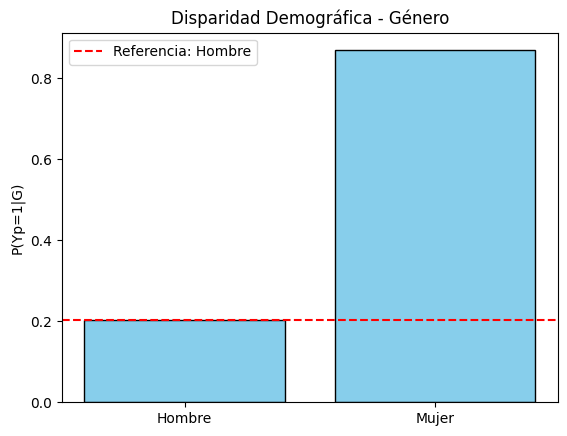

In [11]:
plot_DDsp(sp_gender, 'Sexo', 'Disparidad Demográfica - Género', ref_gender)

In [12]:
#Clase 
df_sp['Clase'] = df_sp[['Pclass_1','Pclass_2','Pclass_3']].idxmax(axis=1).str[-1]
sp_class, ref_class = demographic_disparity(df_sp, 'Clase')
print('\nDisparidad Demográfica por Clase:\n', sp_class)


Disparidad Demográfica por Clase:
   Clase  P(Yp=1|G)  Diferencia     Ratio
0     1   0.711111    0.000000  1.000000
1     2   0.558824   -0.152288  0.785846
2     3   0.260000   -0.451111  0.365625


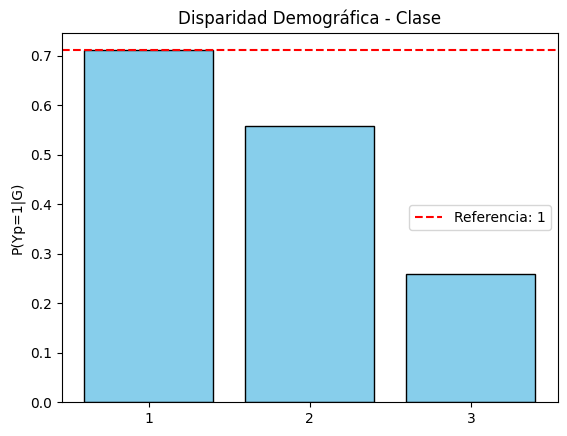

In [13]:
plot_DDsp(sp_class, 'Clase', 'Disparidad Demográfica - Clase', ref_class)

In [14]:
#Edad
sp_age, ref_age = demographic_disparity(df_sp, 'AgeGroup_ordinal')
print('\nDisparidad Demográfica por Edad:\n', sp_age)


Disparidad Demográfica por Edad:
    AgeGroup_ordinal  P(Yp=1|G)  Diferencia     Ratio
0                 1   0.714286    0.000000  1.000000
1                 2   0.541667   -0.172619  0.758333
2                 3   0.361905   -0.352381  0.506667
3                 4   0.483871   -0.230415  0.677419
4                 5   0.200000   -0.514286  0.280000


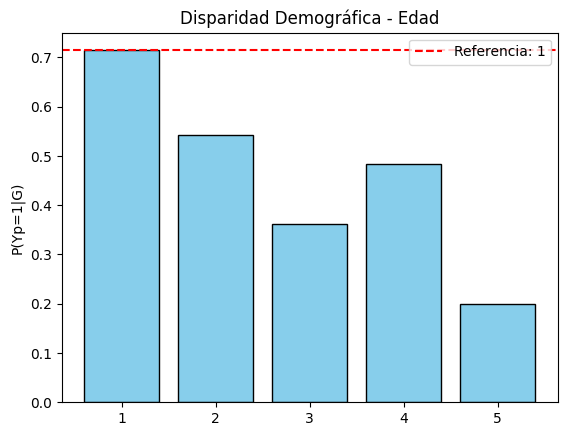

In [15]:
plot_DDsp(sp_age, 'AgeGroup_ordinal', 'Disparidad Demográfica - Edad', ref_age)

## Igualdad de Oportunidad (Equal Opportunity)

In [16]:
def equal_opportunity(df, group, true_col='Survived', pred_col='y_pred'):
    #Calcula el True Positive Rate (TPR) por grupo.
    df_1s = df[df[true_col] == 1]  

    results = (
        df_1s.groupby(group)[pred_col]
        .mean()
        .reset_index()
        .rename(columns={pred_col: 'TPR'})
    )

    return results

In [17]:
#Género
eo_gender = equal_opportunity(df_sp, 'Sexo')
print('\nTPR por Género:\n', eo_gender)


TPR por Género:
      Sexo       TPR
0  Hombre  0.500000
1   Mujer  0.977778


In [18]:
eo_class = equal_opportunity(df_sp, 'Clase')
print('\nTPR por Clase:\n', eo_class)


TPR por Clase:
   Clase       TPR
0     1  0.840000
1     2  0.900000
2     3  0.708333


In [19]:
eo_age = equal_opportunity(df_sp, 'AgeGroup_ordinal')
print('\nTPR por Edad:\n', eo_age)


TPR por Edad:
    AgeGroup_ordinal       TPR
0                 1  1.000000
1                 2  0.909091
2                 3  0.743590
3                 4  0.800000
4                 5  1.000000


¿Quién se beneficia más?

## Odds Equalizados (Equalized Odds)

In [20]:
def equalized_odds(df, group, true_col='Survived', pred_col='y_pred'):
    #Calcula TPR, FPR y Precisión por grupo.
    
    results = []

    for g, subset in df.groupby(group):
        tn, fp, fn, tp = confusion_matrix(subset[true_col], subset[pred_col], labels=[0,1]).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilidad
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # 1 - Especificidad
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        results.append({
            group: g,
            'TPR': tpr,
            'FPR': fpr,
            'Precision': precision
        })

    return pd.DataFrame(results)

In [21]:
#Genero
eodds_gender = equalized_odds(df_sp, 'Sexo')
print('\nEqualized Odds por Género:\n', eodds_gender)


Equalized Odds por Género:
      Sexo       TPR      FPR  Precision
0  Hombre  0.500000  0.12766   0.500000
1   Mujer  0.977778  0.56250   0.830189


In [22]:
#Clase
eodds_class = equalized_odds(df_sp, 'Clase')
print('\nEqualized Odds por Clase:\n', eodds_class)


Equalized Odds por Clase:
   Clase       TPR       FPR  Precision
0     1  0.840000  0.550000   0.656250
1     2  0.900000  0.071429   0.947368
2     3  0.708333  0.118421   0.653846


In [23]:
#Edad
eodds_age = equalized_odds(df_sp, 'AgeGroup_ordinal')
print('\nEqualized Odds por Edad:\n', eodds_age)


Equalized Odds por Edad:
    AgeGroup_ordinal       TPR       FPR  Precision
0                 1  1.000000  0.333333   0.800000
1                 2  0.909091  0.230769   0.769231
2                 3  0.743590  0.136364   0.763158
3                 4  0.800000  0.333333   0.533333
4                 5  1.000000  0.000000   1.000000


Trade-offs identificados

## Calibración por grupo

In [24]:
def calibration_by_group(df, group, true_col='Survived', prob_col='y_prob', n_bins=10):
    #Calcula curvas de calibración por grupo usando bins de probabilidad
    
    results = {}

    for g, subset in df.groupby(group):
        y_true = subset[true_col]
        y_prob = subset[prob_col]

        frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

        results[g] = pd.DataFrame({
            'mean_pred': mean_pred,
            'frac_pos': frac_pos
        })

    return results

In [25]:
def plot_calibration(results, title):
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], 'k--', label='Calibración ideal')
    for g, df_group in results.items():
        plt.plot(df_group['mean_pred'], df_group['frac_pos'], marker='o', label=g)
    plt.xlabel('Probabilidad predicha promedio')
    plt.ylabel('Frecuencia observada')
    plt.title(title)
    plt.legend()
    plt.show()

In [26]:
df_sp['y_prob'] = y_proba

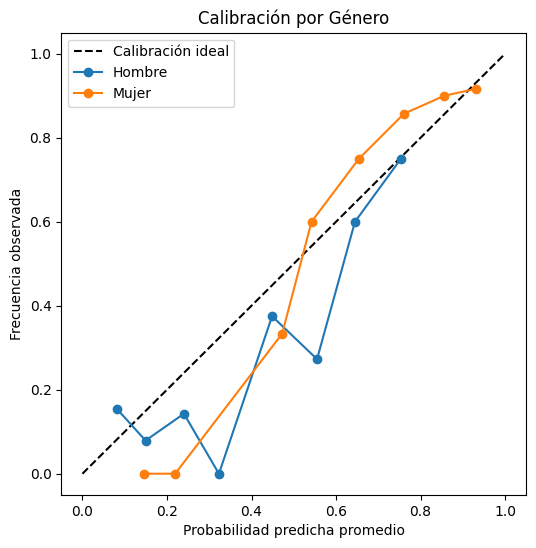

In [27]:
#Género
cal_gender = calibration_by_group(df_sp, 'Sexo')
plot_calibration(cal_gender, 'Calibración por Género')

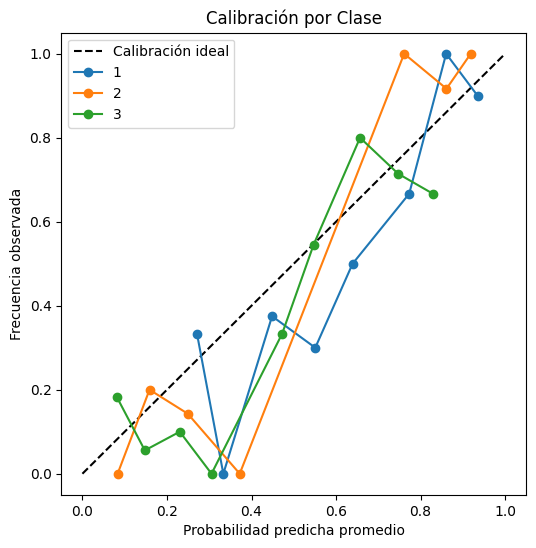

In [28]:
#Clase
cal_class = calibration_by_group(df_sp, 'Clase')
plot_calibration(cal_class, 'Calibración por Clase')

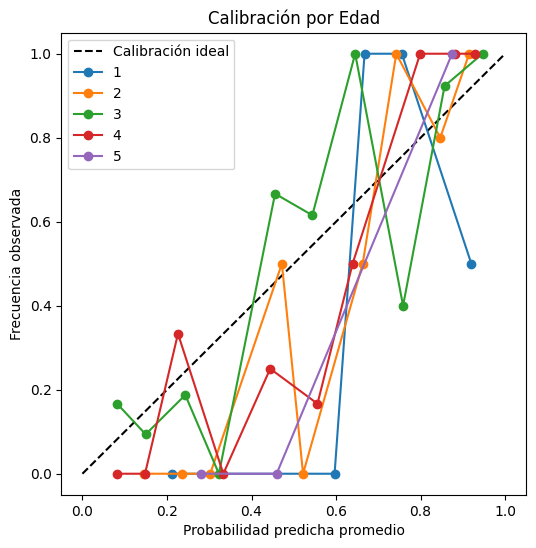

In [29]:
#Edad
cal_age = calibration_by_group(df_sp, 'AgeGroup_ordinal')
plot_calibration(cal_age, 'Calibración por Edad')

Análisis de sobre/sub-estimación

## Análisis interseccional

1. Mujeres de tercera clase vs. hombres de primera clase

In [30]:
df_sp['Grupo1'] = df_sp['Sexo'] + " - Clase " + df_sp['Clase']

group1 = df_sp.groupby('Grupo1').agg(
    Survived_real=('Survived','mean'),
    Survived_pred=('y_prob','mean')
).reset_index()
group1['Diferencia'] = group1['Survived_pred'] - group1['Survived_real']

print('\nMujeres tercera clase vs Hombres primera clase:\n', group1)


Mujeres tercera clase vs Hombres primera clase:
              Grupo1  Survived_real  Survived_pred  Diferencia
0  Hombre - Clase 1       0.366667       0.515107    0.148441
1  Hombre - Clase 2       0.187500       0.240605    0.053105
2  Hombre - Clase 3       0.138889       0.213480    0.074591
3   Mujer - Clase 1       0.933333       0.910010   -0.023323
4   Mujer - Clase 2       0.944444       0.844746   -0.099698
5   Mujer - Clase 3       0.500000       0.539563    0.039563


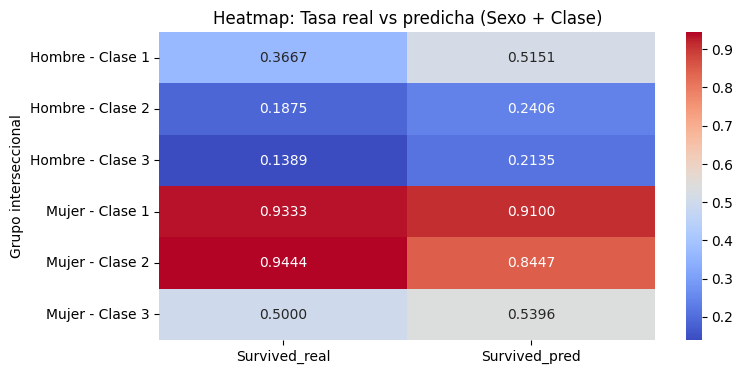

In [31]:
plt.figure(figsize=(8,4))
pivot1 = group1.set_index('Grupo1')[['Survived_real','Survived_pred']]
sns.heatmap(pivot1, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Heatmap: Tasa real vs predicha (Sexo + Clase)")
plt.ylabel("Grupo interseccional")
plt.show()

2. Niños de diferentes clases sociales

In [32]:
df_sp['Grupo2'] = "Clase " + df_sp['Clase'] + " - Edad " + df_sp['AgeGroup_ordinal'].astype(str)

group2 = df_sp.groupby('Grupo2').agg(
    Survived_real=('Survived','mean'),
    Survived_pred=('y_prob','mean')
).reset_index()
group2['Diferencia'] = group2['Survived_pred'] - group2['Survived_real']

print("\nNiños de diferentes clases:\n", group2[group2['Grupo2'].str.contains("Edad 1")])


Niños de diferentes clases:
              Grupo2  Survived_real  Survived_pred  Diferencia
0  Clase 1 - Edad 1            0.5       0.842108    0.342108
5  Clase 2 - Edad 1            1.0       0.846315   -0.153685
9  Clase 3 - Edad 1            0.5       0.510915    0.010915


In [33]:
print("\nNiños de diferentes clases:\n", group2[group2['Grupo2'].str.contains("Edad 2")])


Niños de diferentes clases:
               Grupo2  Survived_real  Survived_pred  Diferencia
1   Clase 1 - Edad 2       1.000000       0.904339   -0.095661
6   Clase 2 - Edad 2       0.750000       0.632087   -0.117913
10  Clase 3 - Edad 2       0.294118       0.456583    0.162465


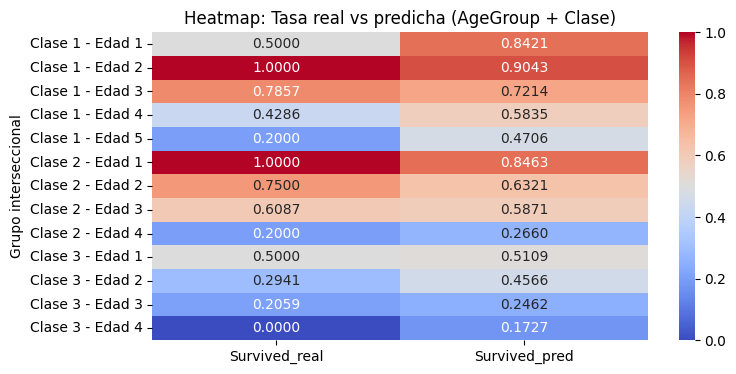

In [34]:
plt.figure(figsize=(8,4))
pivot2 = group2.set_index('Grupo2')[['Survived_real','Survived_pred']]
sns.heatmap(pivot2, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Heatmap: Tasa real vs predicha (AgeGroup + Clase)")
plt.ylabel("Grupo interseccional")
plt.show()

3. Ancianos por género y clase

In [35]:
df_sp['Grupo3'] = df_sp['Sexo'] + " - Clase " + df_sp['Clase'] + " - Edad " + df_sp['AgeGroup_ordinal'].astype(str)

group3 = df_sp.groupby('Grupo3').agg(
    Survived_real=('Survived','mean'),
    Survived_pred=('y_prob','mean')
).reset_index()
group3['Diferencia'] = group3['Survived_pred'] - group3['Survived_real']

print("\nAncianos por género y clase:\n", group3[group3['Grupo3'].str.contains(f"Edad 5")])


Ancianos por género y clase:
                        Grupo3  Survived_real  Survived_pred  Diferencia
3   Hombre - Clase 1 - Edad 5            0.0       0.369599    0.369599
16   Mujer - Clase 1 - Edad 5            1.0       0.874482   -0.125518


In [36]:
df_sp['Grupo3'] = df_sp['Sexo'] + " - Clase " + df_sp['Clase'] + " - Edad " + df_sp['AgeGroup_ordinal'].astype(str)

group3 = df_sp.groupby('Grupo3').agg(
    Survived_real=('Survived','mean'),
    Survived_pred=('y_prob','mean')
).reset_index()
group3['Diferencia'] = group3['Survived_pred'] - group3['Survived_real']

print("\nAdultos por género y clase:\n", group3[group3['Grupo3'].str.contains(f"Edad 4")])


Adultos por género y clase:
                        Grupo3  Survived_real  Survived_pred  Diferencia
2   Hombre - Clase 1 - Edad 4       0.294118       0.505294    0.211177
7   Hombre - Clase 2 - Edad 4       0.000000       0.132808    0.132808
11  Hombre - Clase 3 - Edad 4       0.000000       0.172668    0.172668
15   Mujer - Clase 1 - Edad 4       1.000000       0.915799   -0.084201
20   Mujer - Clase 2 - Edad 4       1.000000       0.798970   -0.201030


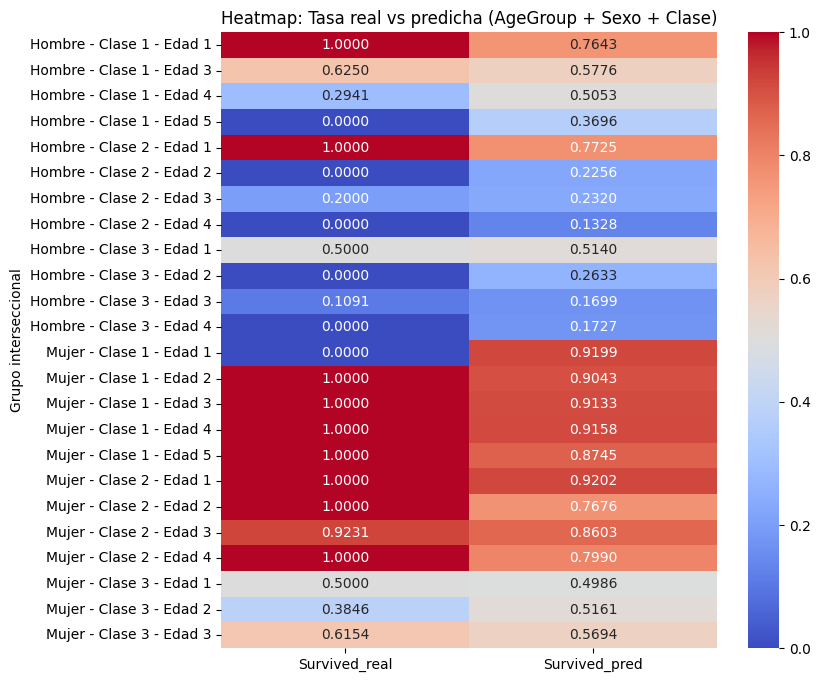

In [37]:
plt.figure(figsize=(8,8))
pivot3 = group3.set_index('Grupo3')[['Survived_real','Survived_pred']]
sns.heatmap(pivot3, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Heatmap: Tasa real vs predicha (AgeGroup + Sexo + Clase)")
plt.ylabel("Grupo interseccional")
plt.show()

## Análisis de grupos más desfavorecidos por el modelo

In [38]:
desf_groups=group3[group3['Diferencia']<0]
desf_groups.sort_values('Diferencia')

,Grupo3,Survived_real,Survived_pred,Diferencia
0,Hombre - Clase 1 - Edad 1,1.000000,0.764282,-0.235718
18,Mujer - Clase 2 - Edad 2,1.000000,0.767579,-0.232421
4,Hombre - Clase 2 - Edad 1,1.000000,0.772461,-0.227539
20,Mujer - Clase 2 - Edad 4,1.000000,0.798970,-0.201030
16,Mujer - Clase 1 - Edad 5,1.000000,0.874482,-0.125518
13,Mujer - Clase 1 - Edad 2,1.000000,0.904339,-0.095661
14,Mujer - Clase 1 - Edad 3,1.000000,0.913253,-0.086747
15,Mujer - Clase 1 - Edad 4,1.000000,0.915799,-0.084201
17,Mujer - Clase 2 - Edad 1,1.000000,0.920168,-0.079832
19,Mujer - Clase 2 - Edad 3,0.923077,0.860274,-0.062803
